## MSWEP Preprocessing Methods for CNN-Based Downscaling

In [1]:
import xarray as xr
import numpy as np
import h5py
import os
import shutil

from tqdm import tqdm
from pathlib import Path
from sklearn.preprocessing import RobustScaler, MinMaxScaler

# Set datasets name
DatasetsName        = 'GJ_04_01'
Normalized          = True

# Path Define
# Get the absolute path 
pathNow = Path().parent.absolute() #See @Arminius answer
pathNow = pathNow.parent
print(pathNow)

# Define the base directory where MSWEP files are stored
mswepDir            = str(pathNow) + "/Datasets/Ina_MSWEP/"

# Report Filename 
DatasetsFolder      = pathNow / 'Rifqi.Code' / 'Datasets' / DatasetsName 

# Define HDF5 file name
hdf5Training    = DatasetsFolder / "mswepTrain.h5"
hdf5Validation  = DatasetsFolder / "mswepValidation.h5"
hdf5Testing     = DatasetsFolder / "mswepTesting.h5"

c:\Users\rifqi\UNIVERSITAS INDONESIA\BMKG Research 3 - 2025.PrecipitationProjection


### 1. Handling Zero-Inflation and Skewness

In [2]:
def logarithmicTransform(data, epsilon=0.1):
    """Apply preprocessing to handle zero-inflation and skewness"""
    # Log transformation with epsilon
    transformed = np.log1p(data + epsilon)
    return transformed

### 2. Stratified Scaling for Different Precipitation Intensities

In [3]:
# For stratified scaling, modify the function to handle xarray objects
def stratifiedScaling(data, threshold=1.0):
    """Stratified scaling that works with both numpy arrays and xarray DataArrays"""
    # Convert to numpy if it's an xarray DataArray
    if hasattr(data, 'values'):
        numpy_data = data.values
    else:
        numpy_data = data
        
    # Create a copy of the input data
    result = np.zeros_like(numpy_data)
    
    # Get original shape and flatten
    original_shape = numpy_data.shape
    data_flat = numpy_data.flatten()
    
    # Create separate arrays for each intensity level
    no_rain = data_flat < 0.1
    light_rain = (data_flat >= 0.1) & (data_flat < threshold)
    heavy_rain = data_flat >= threshold
    
    # Handle light rain
    if np.any(light_rain):
        light_values = data_flat[light_rain]
        light_scaler = RobustScaler()
        scaled_light = light_scaler.fit_transform(light_values.reshape(-1, 1)).ravel()
        
        # Create a temporary array to hold the scaled values
        temp = np.zeros_like(data_flat)
        temp[light_rain] = scaled_light
        
        # Add to result
        result += temp.reshape(original_shape)
    
    # Handle heavy rain
    if np.any(heavy_rain):
        heavy_values = data_flat[heavy_rain]
        heavy_scaler = RobustScaler()
        scaled_heavy = heavy_scaler.fit_transform(heavy_values.reshape(-1, 1)).ravel()
        
        # Create a temporary array to hold the scaled values
        temp = np.zeros_like(data_flat)
        temp[heavy_rain] = scaled_heavy
        
        # Add to result
        result += temp.reshape(original_shape)
    
    return result


### 3. Outlier Handling

In [4]:
def handleOutliers(data, threshold=50):
    """
    Handle extreme precipitation values
    
    Args:
        data: Input precipitation array
        threshold: Maximum allowed precipitation value (mm)
        
    Returns:
        Precipitation with outliers handled
    """
    # Option 1: Clipping (simplest approach)
    clipped_data = np.clip(data, 0, threshold)
    
    # Option 2: Winsorizing (less aggressive than clipping)
    # from scipy import stats
    # winsorized = stats.mstats.winsorize(data, limits=[0, 0.05])  # Cap top 5%
    
    # Option 3: Identify and flag outliers in a separate channel
    # outlier_mask = (data > threshold).astype(np.float32)
    # return clipped_data, outlier_mask
    
    return clipped_data

### 4. Spatial Pattern Enhancement

In [5]:
def enhanceSpatialPatterns(data, sigma=1.0):
    """
    Enhance spatial patterns in precipitation fields
    
    Args:
        data: Input precipitation array
        sigma: Gaussian filter parameter
        
    Returns:
        Original data and enhanced spatial features
    """
    from scipy import ndimage
    
    # Calculate spatial gradients
    grad_x = ndimage.sobel(data, axis=0)
    grad_y = ndimage.sobel(data, axis=1)
    
    # Calculate gradient magnitude
    gradient_magnitude = np.sqrt(grad_x**2 + grad_y**2)
    
    # Smooth data to highlight larger patterns
    smoothed = ndimage.gaussian_filter(data, sigma=sigma)
    
    # Return original and derived features
    return data, gradient_magnitude, smoothed

### 5. Cross-Scale Consistency Features

In [6]:
def calculate_cross_scale_features(high_res_data, scale_factor=10):
    """
    Calculate features that maintain consistency across resolutions
    
    Args:
        high_res_data: High-resolution precipitation array
        scale_factor: Factor for downscaling (e.g., 10 for 0.1° to 0.01°)
        
    Returns:
        Dictionary of cross-scale features
    """
    # Original shape
    orig_shape = high_res_data.shape
    
    # Create low-resolution version by averaging
    # Reshape to group pixels by scale_factor x scale_factor blocks
    h, w = orig_shape[0], orig_shape[1]
    h_lr = h // scale_factor
    w_lr = w // scale_factor
    
    # Ensure divisibility by scale_factor
    h_scaled = h_lr * scale_factor
    w_scaled = w_lr * scale_factor
    
    # Crop to make divisible
    cropped = high_res_data[:h_scaled, :w_scaled]
    
    # Reshape to perform averaging
    reshaped = cropped.reshape(h_lr, scale_factor, w_lr, scale_factor)
    low_res = reshaped.mean(axis=(1, 3))
    
    # Calculate mean and standard deviation within each block
    std_dev = reshaped.std(axis=(1, 3))
    
    # Calculate fraction of rainy cells in each block
    rain_threshold = 0.1  # mm/day
    rain_fraction = (reshaped > rain_threshold).mean(axis=(1, 3))
    
    # Calculate maximum precipitation in each block
    max_precip = reshaped.max(axis=(1, 3))
    
    # Upsample these statistics back to high resolution
    # (For training consistency features)
    std_dev_upscaled = np.repeat(np.repeat(std_dev, scale_factor, axis=0), 
                                 scale_factor, axis=1)
    rain_fraction_upscaled = np.repeat(np.repeat(rain_fraction, scale_factor, axis=0), 
                                       scale_factor, axis=1)
    max_precip_upscaled = np.repeat(np.repeat(max_precip, scale_factor, axis=0), 
                                    scale_factor, axis=1)
    
    # Crop back to original size if needed
    if std_dev_upscaled.shape != orig_shape:
        std_dev_upscaled = np.pad(std_dev_upscaled, 
                                 ((0, orig_shape[0]-std_dev_upscaled.shape[0]), 
                                  (0, orig_shape[1]-std_dev_upscaled.shape[1])))
        rain_fraction_upscaled = np.pad(rain_fraction_upscaled, 
                                       ((0, orig_shape[0]-rain_fraction_upscaled.shape[0]), 
                                        (0, orig_shape[1]-rain_fraction_upscaled.shape[1])))
        max_precip_upscaled = np.pad(max_precip_upscaled, 
                                    ((0, orig_shape[0]-max_precip_upscaled.shape[0]), 
                                     (0, orig_shape[1]-max_precip_upscaled.shape[1])))
    
    return {
        'std_dev': std_dev_upscaled,
        'rain_fraction': rain_fraction_upscaled,
        'max_precip': max_precip_upscaled,
        'low_res': low_res
    }

### 6. Temporal Feature Extraction for Seasonal Context

In [7]:
def extract_temporal_features(time_values):
    """
    Extract temporal features from precipitation time series dates
    
    Args:
        time_values: Array of datetime values
        
    Returns:
        Dictionary of temporal features
    """
    import pandas as pd
    
    # Convert to pandas datetime if not already
    if not isinstance(time_values[0], pd.Timestamp):
        time_values = pd.to_datetime(time_values)
    
    # Extract basic time components
    hour_of_day = np.array([t.hour for t in time_values])
    day_of_year = np.array([t.dayofyear for t in time_values])
    month = np.array([t.month for t in time_values])
    
    # Calculate season (1=winter, 2=spring, 3=summer, 4=fall)
    season = np.array([(m % 12 + 3) // 3 for m in month])
    
    # Convert to cyclical features using sine and cosine
    hour_sin = np.sin(2 * np.pi * hour_of_day / 24)
    hour_cos = np.cos(2 * np.pi * hour_of_day / 24)
    day_sin = np.sin(2 * np.pi * day_of_year / 365)
    day_cos = np.cos(2 * np.pi * day_of_year / 365)
    month_sin = np.sin(2 * np.pi * month / 12)
    month_cos = np.cos(2 * np.pi * month / 12)
    
    return {
        'hour_sin': hour_sin,
        'hour_cos': hour_cos,
        'day_sin': day_sin,
        'day_cos': day_cos,
        'month_sin': month_sin,
        'month_cos': month_cos,
        'season': season
    }

### 7. Data Augmentation for Precipitation Fields

In [8]:
def augment_precipitation_field(precip_field, max_rotation=10, flip_prob=0.5):
    """
    Perform data augmentation on precipitation fields
    
    Args:
        precip_field: 2D precipitation array
        max_rotation: Maximum rotation angle in degrees
        flip_prob: Probability of flipping the field
        
    Returns:
        Augmented precipitation field
    """
    from scipy import ndimage
    import numpy as np
    
    # Make a copy to avoid modifying the original
    augmented = precip_field.copy()
    
    # 1. Random rotation (small angles to preserve meteorological realism)
    if max_rotation > 0:
        angle = np.random.uniform(-max_rotation, max_rotation)
        augmented = ndimage.rotate(augmented, angle, reshape=False, mode='nearest')
    
    # 2. Random flips (meteorologically reasonable in many cases)
    if np.random.random() < flip_prob:
        augmented = np.fliplr(augmented)
    
    # 3. Small random noise (to simulate observational uncertainty)
    # Scale noise by precipitation intensity to maintain physical realism
    noise_scale = 0.05 * (augmented + 0.1)  # 5% noise, avoiding zeros
    noise = np.random.normal(0, noise_scale)
    augmented = np.maximum(0, augmented + noise)  # Ensure non-negative
    
    return augmented

### Preprocessing Pipeline

In [9]:
def preprocess_mswep_sample(precip_field, include_augmentation=False, 
                          outlier_threshold=200, epsilon=0.1):
    """
    Complete preprocessing pipeline for a single MSWEP precipitation field
    
    Args:
        precip_field: 2D or 3D precipitation array
        include_augmentation: Whether to apply data augmentation
        outlier_threshold: Threshold for outlier handling
        epsilon: Small value for log transform
        
    Returns:
        Preprocessed precipitation field
    """
    # Ensure we're working with 2D field for processing
    original_shape = precip_field.shape
    if len(original_shape) == 3:
        # Extract single channel
        precip_2d = precip_field[:, :, 0]
    else:
        precip_2d = precip_field
    
    # 1. Handle outliers
    precip_2d = handleOutliers(precip_2d, threshold=outlier_threshold)
    
    # 2. Optional data augmentation
    if include_augmentation:
        precip_2d = augment_precipitation_field(precip_2d)
    
    # 3. Log transformation
    precip_log = logarithmicTransform(precip_2d, epsilon=epsilon)
    
    # 4. Stratified scaling
    precip_scaled = stratifiedScaling(precip_log)
    
    # 5. Spatial pattern enhancement
    precip_orig, gradient_mag, precip_smoothed = enhanceSpatialPatterns(precip_scaled)
    
    # Combine the fields into multi-channel format for CNN input
    processed = np.stack([precip_scaled, gradient_mag, precip_smoothed], axis=-1)
    
    return processed

### Visualization of Preprocessing Effects

In [10]:
def visualize_preprocessing_steps(original_field, epsilon=0.1):
    """
    Visualize the effects of different preprocessing steps
    """
    import matplotlib.pyplot as plt
    import numpy as np
    from sklearn.preprocessing import RobustScaler
    
    # Convert to numpy array if it's an xarray DataArray
    if hasattr(original_field, 'values'):
        field = original_field.values.copy()
    else:
        field = original_field.copy()
    
    # Apply different preprocessing steps
    log_transformed = np.log1p(field + epsilon)
    cube_root = np.cbrt(field)
    
    # Transform entire arrays with RobustScaler
    scaler = RobustScaler()
    
    # Make sure field is 2D
    if field.ndim > 2:
        field = field[:,:,0]  # Take first channel if it's 3D
    
    # Now apply preprocessings
    original_scaled = scaler.fit_transform(field.reshape(-1, 1)).reshape(field.shape)
    log_scaled = scaler.fit_transform(log_transformed.reshape(-1, 1)).reshape(log_transformed.shape)
    cbrt_scaled = scaler.fit_transform(cube_root.reshape(-1, 1)).reshape(cube_root.shape)
        
    
    # Apply the fixed stratified scaling function
    stratified = stratifiedScaling(log_transformed)
    
    # Continue with visualization...
    # Create visualization
    fig, axs = plt.subplots(2, 4, figsize=(20, 10))
    
    # First row: Spatial patterns
    im0 = axs[0, 0].imshow(original_scaled, cmap='Blues')
    axs[0, 0].set_title('Original')
    plt.colorbar(im0, ax=axs[0, 0])
    
    im1 = axs[0, 1].imshow(log_transformed, cmap='Blues')
    axs[0, 1].set_title('Log Transform')
    plt.colorbar(im1, ax=axs[0, 1])
    
    im2 = axs[0, 2].imshow(cube_root, cmap='Blues')
    axs[0, 2].set_title('Cube Root')
    plt.colorbar(im2, ax=axs[0, 2])
    
    im3 = axs[0, 3].imshow(stratified, cmap='Blues')
    axs[0, 3].set_title('Stratified Scaling')
    plt.colorbar(im3, ax=axs[0, 3])
    
    # Second row: Histograms
    # Remove zeros for better visualization
    field_nz = field[field > 0]
    log_nz = log_transformed[log_transformed > 0]
    cbrt_nz = cube_root[cube_root > 0]
    
    axs[1, 0].hist(field_nz.flatten(), bins=50)
    axs[1, 0].set_title('Original Histogram')
    axs[1, 0].set_yscale('log')
    
    axs[1, 1].hist(log_nz.flatten(), bins=50)
    axs[1, 1].set_title('Log Transform Histogram')
    
    axs[1, 2].hist(cbrt_nz.flatten(), bins=50)
    axs[1, 2].set_title('Cube Root Histogram')
    
    axs[1, 3].hist(stratified.flatten(), bins=50)
    axs[1, 3].set_title('Stratified Scaling Histogram')
    
    plt.tight_layout()
    plt.show()

## View Datasets Sample

Loaded Original Train Data Shape: (9497, 16, 16, 1)
Loaded Low Resolution Train Data Shape: (9497, 4, 4, 1)
Loaded Original Validation Data Shape: (730, 16, 16, 1)
Loaded Original Test Data Shape: (731, 16, 16, 1)


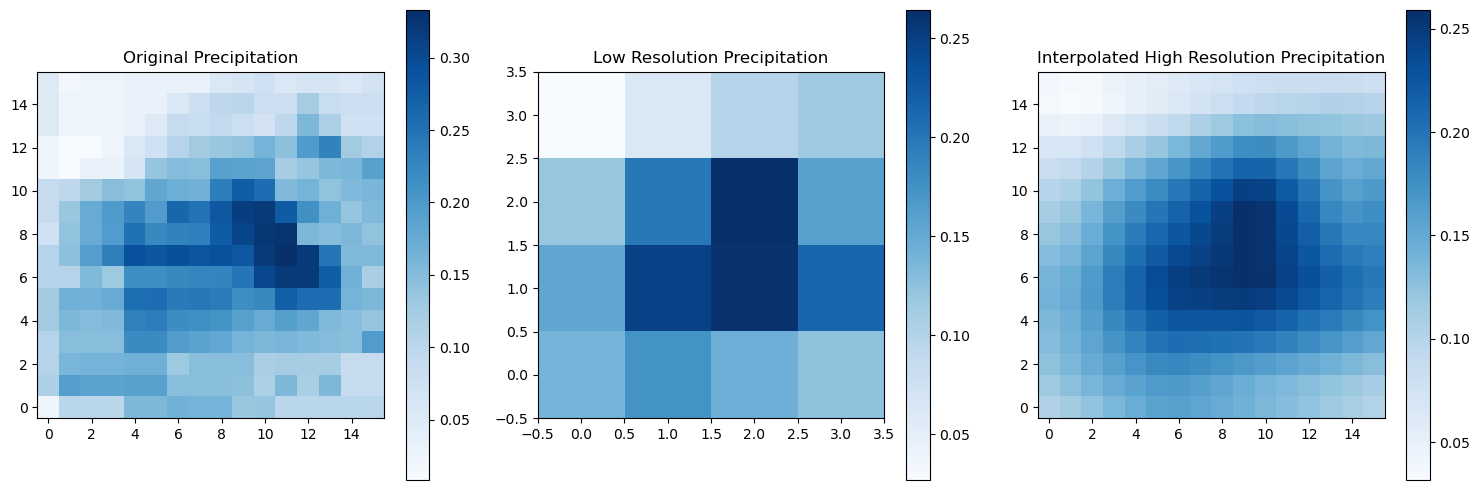

In [11]:
# Load dataset from HDF5
with h5py.File(hdf5Training, "r") as hf:
    precipTrainOriginal = hf["precipTrainOriginal"][:]
    precipLowResTrain   = hf["precipLowResTrain"][:]
    precipHighResTrain  = hf["precipHighResTrain"][:]
    if Normalized:
        scale_          = hf["scale_"][:]           # Loading Min Max Scaler Parameter
        min_            = hf["min_"][:]
        data_min_       = hf["data_min_"][:]
        data_max_       = hf["data_max_"][:]
        feature_range   = hf["feature_range"][:]        
    print("Loaded Original Train Data Shape:", precipHighResTrain.shape)
    print("Loaded Low Resolution Train Data Shape:", precipLowResTrain.shape)

with h5py.File(hdf5Validation, "r") as hf:
    precipValOriginal   = hf["precipValOriginal"][:]
    precipLowResVal     = hf["precipLowResVal"][:]
    precipHighResVal    = hf["precipHighResVal"][:]
    print("Loaded Original Validation Data Shape:", precipHighResVal.shape)
    
with h5py.File(hdf5Testing, "r") as hf:
    precipTestOriginal  = hf["precipTestOriginal"][:]
    precipLowResTest    = hf["precipLowResTest"][:]
    precipHighResTest   = hf["precipHighResTest"][:]
    print("Loaded Original Test Data Shape:", precipHighResTest.shape)  

# Plot a random time slice
import matplotlib.pyplot as plt

OriginalImage   = precipTrainOriginal[100, :, :, 0]
LowResImage     = precipLowResTrain[100, :, :, 0]
HighResrImage   = precipHighResTrain[100, :, :, 0]

# Create a figure with three subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot original image
im1 = axes[0].imshow(OriginalImage, cmap="Blues", origin="lower")
axes[0].set_title("Original Precipitation")
fig.colorbar(im1, ax=axes[0])

# Plot low-resolution image
im2 = axes[1].imshow(LowResImage, cmap="Blues", origin="lower")
axes[1].set_title("Low Resolution Precipitation")
fig.colorbar(im2, ax=axes[1])

# Plot high-resolution image
im3 = axes[2].imshow(HighResrImage, cmap="Blues", origin="lower")
axes[2].set_title("Interpolated High Resolution Precipitation")
fig.colorbar(im3, ax=axes[2])

# Adjust layout
plt.tight_layout()
plt.show()

## Run PreProcessing Sample

(16, 16)


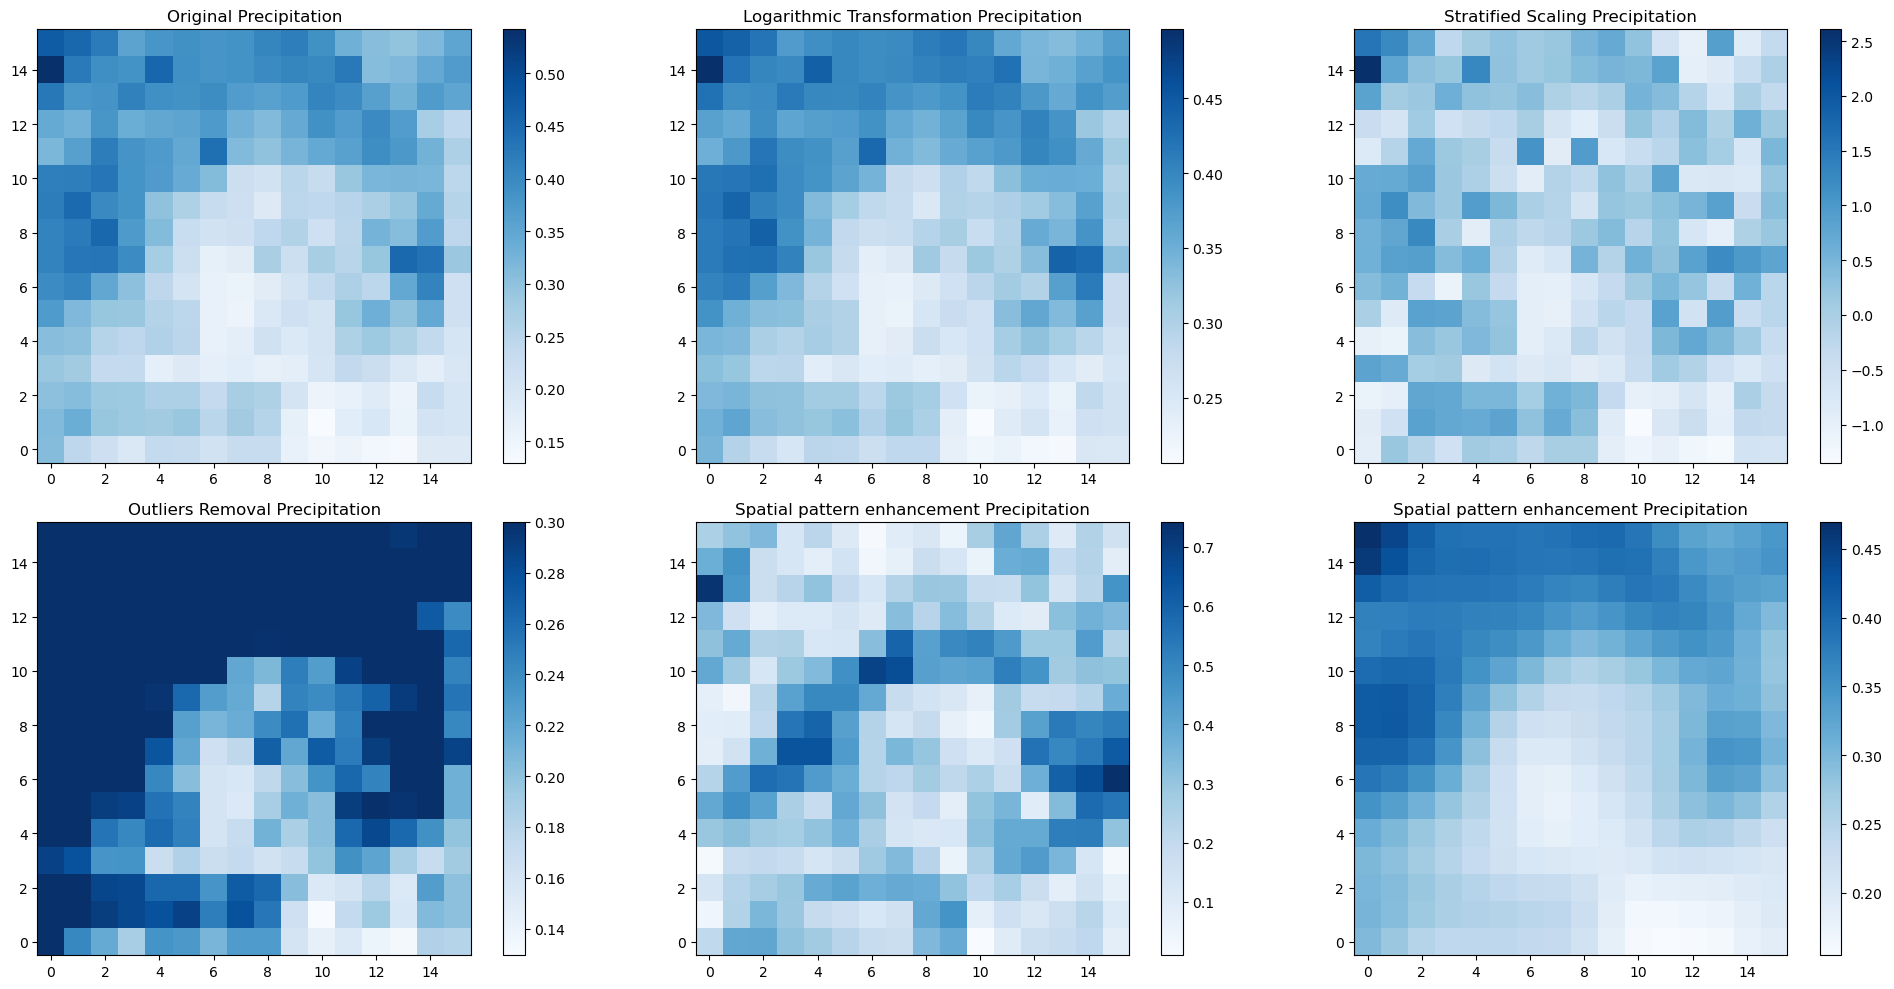

In [12]:
# Extract precipitation data (update variable name if needed)
precip              = precipTrainOriginal[8000,:,:,:]
outlier_threshold   = 0.3

# Ensure we're working with 2D field for processing
original_shape = precip.shape
if len(original_shape) == 3:
    # Extract single channel
    precip_2d = precip[:, :, 0]
else:
    precip_2d = precip

print(precip_2d.shape)

# Log Transformation
precipLogTrans      = logarithmicTransform(precip_2d, epsilon=0.1)

# Stratified Scaling
precipStratScal     = stratifiedScaling(precip_2d, threshold=outlier_threshold)

# Handle outliers
precipOutliers      = handleOutliers(precip_2d, threshold=outlier_threshold)

# Spatial pattern enhancement
precip_orig, gradient_mag, precip_smoothed = enhanceSpatialPatterns(precip_2d, sigma=1.0)

# Create a figure with three subplots
fig, axes = plt.subplots(2, 3, figsize=(20, 10))

# Plot original image
im0 = axes[0,0].imshow(precip_2d, cmap="Blues", origin="lower")
axes[0,0].set_title("Original Precipitation")
fig.colorbar(im0, ax=axes[0,0])

# Plot Log Transformation image
im1 = axes[0,1].imshow(precipLogTrans, cmap="Blues", origin="lower")
axes[0,1].set_title("Logarithmic Transformation Precipitation")
fig.colorbar(im1, ax=axes[0,1])

# Plot Stratified Scaling image
im2 = axes[0,2].imshow(precipStratScal, cmap="Blues", origin="lower")
axes[0,2].set_title("Stratified Scaling Precipitation")
fig.colorbar(im2, ax=axes[0,2])

# Plot Outliers
im3 = axes[1,0].imshow(precipOutliers, cmap="Blues", origin="lower")
axes[1,0].set_title("Outliers Removal Precipitation")
fig.colorbar(im3, ax=axes[1,0])

# Plot Spatial pattern enhancement image
im4 = axes[1,1].imshow(gradient_mag, cmap="Blues", origin="lower")
axes[1,1].set_title("Spatial pattern enhancement Precipitation")
fig.colorbar(im4, ax=axes[1,1])

# Plot Spatial pattern enhancement image
im5 = axes[1,2].imshow(precip_smoothed, cmap="Blues", origin="lower")
axes[1,2].set_title("Spatial pattern enhancement Precipitation")
fig.colorbar(im5, ax=axes[1,2])

# Adjust layout
plt.tight_layout()
plt.show()


## View Data Distribution using Histogram

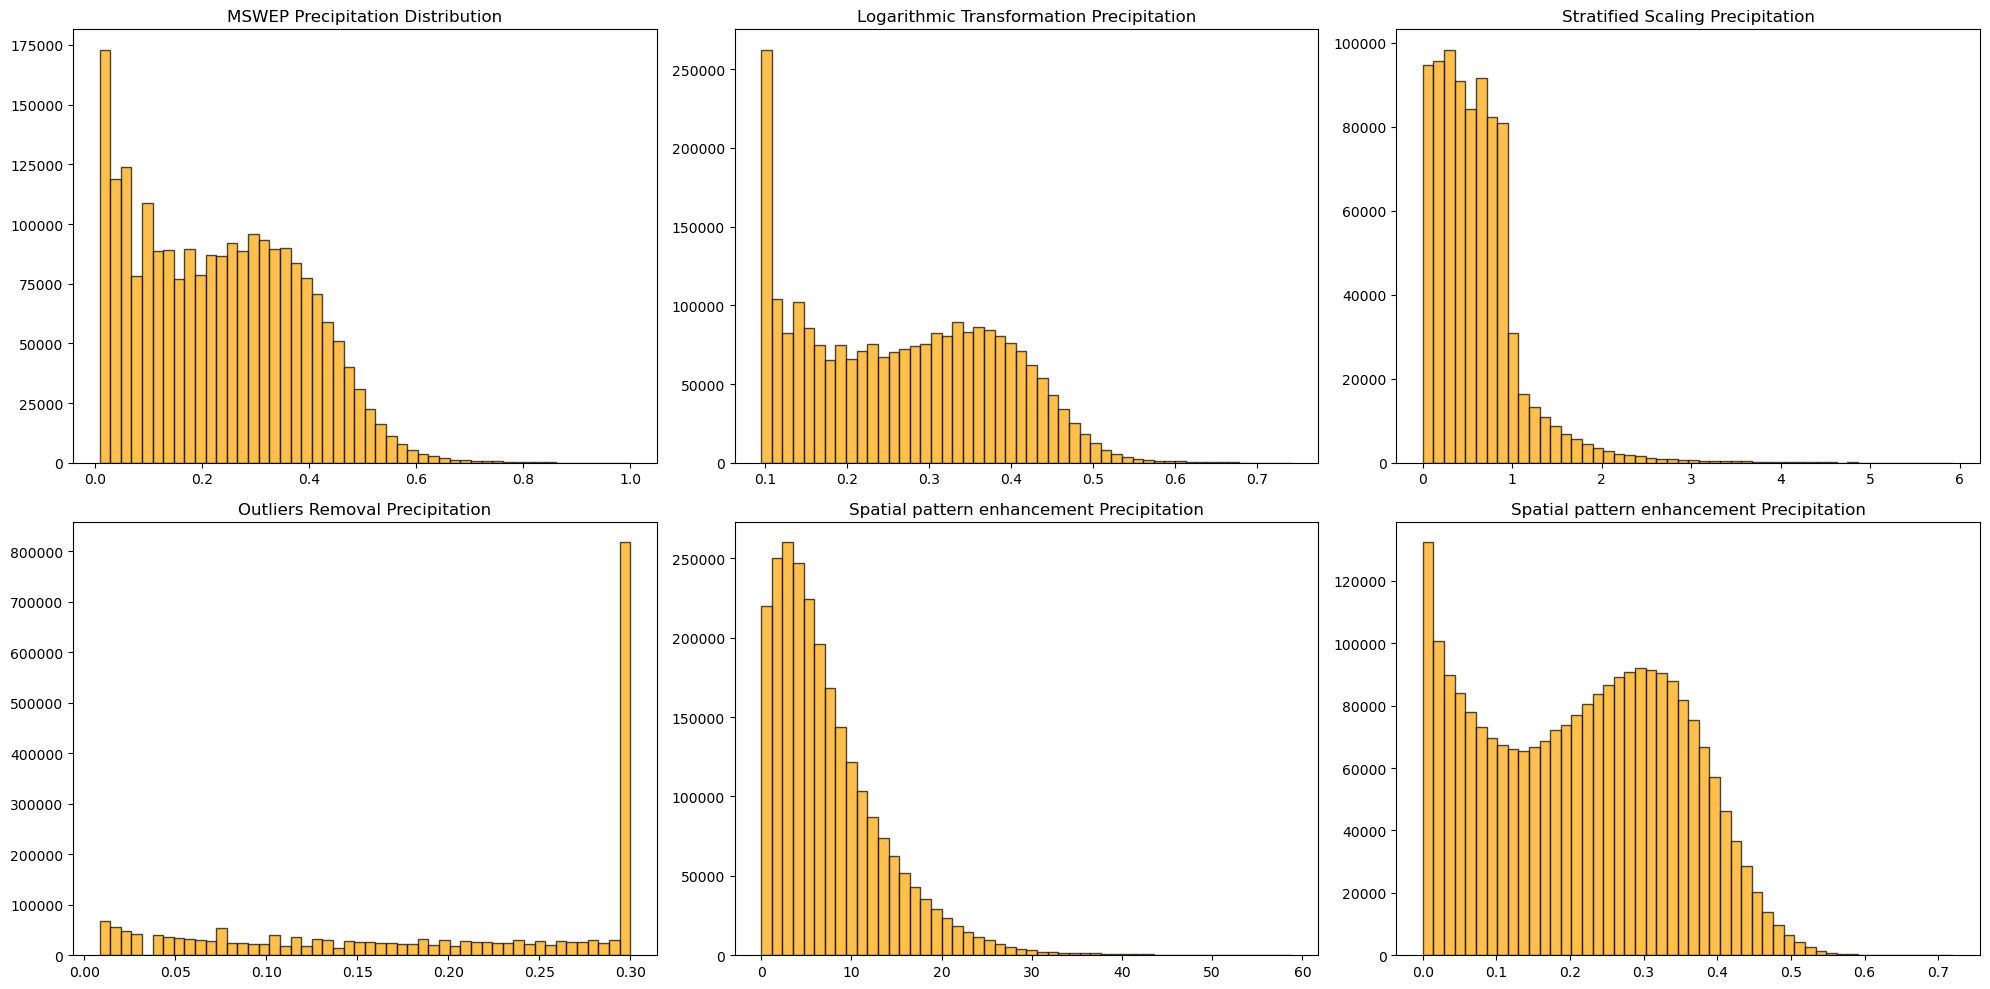

In [13]:
# Log Transformation
precipLogTrans      = logarithmicTransform(precipTrainOriginal, epsilon=0.1)

# Stratified Scaling
precipStratScal     = stratifiedScaling(precipTrainOriginal, threshold=0.3)

# Handle outliers
precipOutliers      = handleOutliers(precipTrainOriginal, threshold=outlier_threshold)

# Spatial pattern enhancement
precip_orig, gradient_mag, precip_smoothed = enhanceSpatialPatterns(precipTrainOriginal, sigma=1.0)

precipTrainOri  = precipTrainOriginal[precipTrainOriginal > 0]
precipLogTrans  = precipLogTrans[precipLogTrans > 0]
precipStratScal = precipStratScal[precipStratScal > 0]
precipOutliers  = precipOutliers[precipOutliers > 0]

# Create a figure with three subplots
fig, axes = plt.subplots(2, 3, figsize=(20, 10))

# Plot original image
im0 = axes[0,0].hist(precipTrainOri.flatten(), bins=50, color='orange', edgecolor='black', alpha=0.7)
axes[0,0].set_title("MSWEP Precipitation Distribution")
# axes[0,0].xlabel("Precipitation (mm)")
# axes[0,0].ylabel("Frequency")

# Plot Log Transformation image
im1 = axes[0,1].hist(precipLogTrans.flatten(), bins=50, color='orange', edgecolor='black', alpha=0.7)
axes[0,1].set_title("Logarithmic Transformation Precipitation")

# Plot Stratified Scaling image
im2 = axes[0,2].hist(precipStratScal.flatten(), bins=50, color='orange', edgecolor='black', alpha=0.7)
axes[0,2].set_title("Stratified Scaling Precipitation")

# Plot Outliers
im3 = axes[1,0].hist(precipOutliers.flatten(), bins=50, color='orange', edgecolor='black', alpha=0.7)
axes[1,0].set_title("Outliers Removal Precipitation")

# Plot Spatial pattern enhancement image
im4 = axes[1,1].hist(gradient_mag.flatten(), bins=50, color='orange', edgecolor='black', alpha=0.7)
axes[1,1].set_title("Spatial pattern enhancement Precipitation")

# Plot Spatial pattern enhancement image
im5 = axes[1,2].hist(precip_smoothed.flatten(), bins=50, color='orange', edgecolor='black', alpha=0.7)
axes[1,2].set_title("Spatial pattern enhancement Precipitation")

# Adjust layout
plt.tight_layout()
plt.show()